In [1]:
import numpy as np
from pathlib import Path
import yaml
from tqdm.notebook import tqdm
from src.dimer import DIMER
from src.anm import ANM
from src.optim import Optimizer
from src.utils import A_0, nm, kT
import matplotlib.pyplot as plt

In [2]:
exp_path = '/scratch/midway3/kirills/WorkCurveOptim/Experiments/more_bindings_v3/'

In [3]:
paths = list(Path(exp_path).glob('*'))

In [4]:
params = {'sep_dist':lambda x: int(x / nm),
          'max_sep_fac':lambda x: x,
          'x_0_init':  lambda x: x,#'fixed' if isinstance(x, list) else 'random',
          'w_reg': lambda x: x,
          'w_phase': lambda x: x,
          'target_dist': lambda x: int(x / nm)}

In [51]:
data_list = list()
for path in tqdm(paths):
    data_point = dict()
    optim_path = str(path / 'optim.pkl')
    hparams_path = str(path / 'params.yaml')
    
    #trial_num = int(optim_path.split('trial=')[-1].split('/')[0])
    trial_num = int(optim_path.split('trial=')[-1].split('-')[0])
    data_point['trial'] = trial_num
    data_point['path'] = path
    
    with open(hparams_path, 'r') as f:
        args = yaml.load(f, Loader=yaml.FullLoader)
    
    for param, func in params.items():
        data_point[param] = func(args[param])
    
    try:
        dimer = DIMER(**args)
        anm = ANM(**args)
        optim = Optimizer(dimer, anm, **args, load_path=optim_path)
    
        diff_mae = np.abs(optim.eval_data['separation'] - optim.target_dist / nm).mean()
        data_point['sep_mae'] = diff_mae
        
        pos = optim.eval_data['pos']
        vec = pos[:, 1] - pos[:, 0] # abs to factor out permuational symmetry
        sim_angles = np.arccos(vec[:, 0] / np.linalg.norm(vec, axis=1))
        data_point['ang_mae'] = np.abs(sim_angles - np.pi / 2.).mean()
        
        data_point['com'] = optim.eval_data['com'].mean()
        
        data_point['dist_loss']= optim.eval_data['dist_loss']
        data_point['orient_loss']= optim.eval_data['orient_loss']
        data_point['reg_loss']= optim.eval_data['reg_loss']
        data_point['phase_loss']= optim.eval_data['phase_loss']
        data_point['total_loss']= optim.eval_data['total_loss']
    except:
        continue
    
    data_list.append(data_point)

  0%|          | 0/1080 [00:00<?, ?it/s]

In [52]:
import hiplot as hip

In [53]:
hip.Experiment.from_iterable([{k:v for k,v in d.items() if k!='path'} for d in data_list]).display(force_full_width=True)

<IPython.core.display.Javascript object>

In [3]:
ID=945

In [4]:
path = data_list[ID]['path']

optim_path = str(path / 'optim.pkl')
hparams_path = str(path / 'params.yaml')

with open(hparams_path, 'r') as f:
    args = yaml.load(f, Loader=yaml.FullLoader)

dimer = DIMER(**args)
anm = ANM(**args)
optim = Optimizer(dimer, anm, **args, load_path=optim_path)

NameError: name 'data_list' is not defined

In [5]:
import matplotlib.pyplot as plt

In [6]:
pos = optim.eval_data['pos']
sim_separation = np.linalg.norm(pos[:, 0] - pos[:, 1], axis=-1) / nm
sim_com = np.mean(pos[:, 0] + pos[:, 1], axis=-1) / nm
t = np.linspace(0, 100, num=sim_separation.size)

plt.figure(dpi=300)
plt.plot(t, sim_separation, label='Policy beam sim')
plt.plot(t, sim_com, label='Policy beam COM')
plt.xlabel('Time (ms)')
plt.ylabel('Separation (nm)')
plt.axhline(y=optim.target_dist / nm, c='r', linestyle='--', label='Target')
plt.axhline(y=0, c='k', linestyle='--')
plt.title("Dimer separation and COM during a policy beam simulation")
plt.legend()
plt.show()

NameError: name 'optim' is not defined

In [7]:
vec = pos[:, 1] - pos[:, 0] # abs to factor out permuational symmetry
sim_angles = np.arccos(vec[:, 0] / np.linalg.norm(vec, axis=1))

plt.figure(dpi=300)
plt.plot(t, sim_angles, label='Policy beam dimer angle')
plt.axhline(y=np.pi/2, c='k', linestyle='--', label='Target')
plt.xlabel('Time (ms)')
plt.ylabel('Angle (radians)')
plt.title("Dimer angle during policy beam simulation")
plt.legend()
plt.show()

NameError: name 'pos' is not defined

In [68]:
anm = optim.anm_gen.get_beam_profile(optim.es.best.x)
anm

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.52002717e-03,
        5.81616448e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  7.07171845e-01,
       -1.92283308e+00,  4.33847663e-01])

In [69]:
W = optim.dimer.calc_radial_work(optim.separation, optim.target_angle, anm)
W_angle = optim.dimer.calc_angular_work(optim.thetas, optim.target_dist, anm)

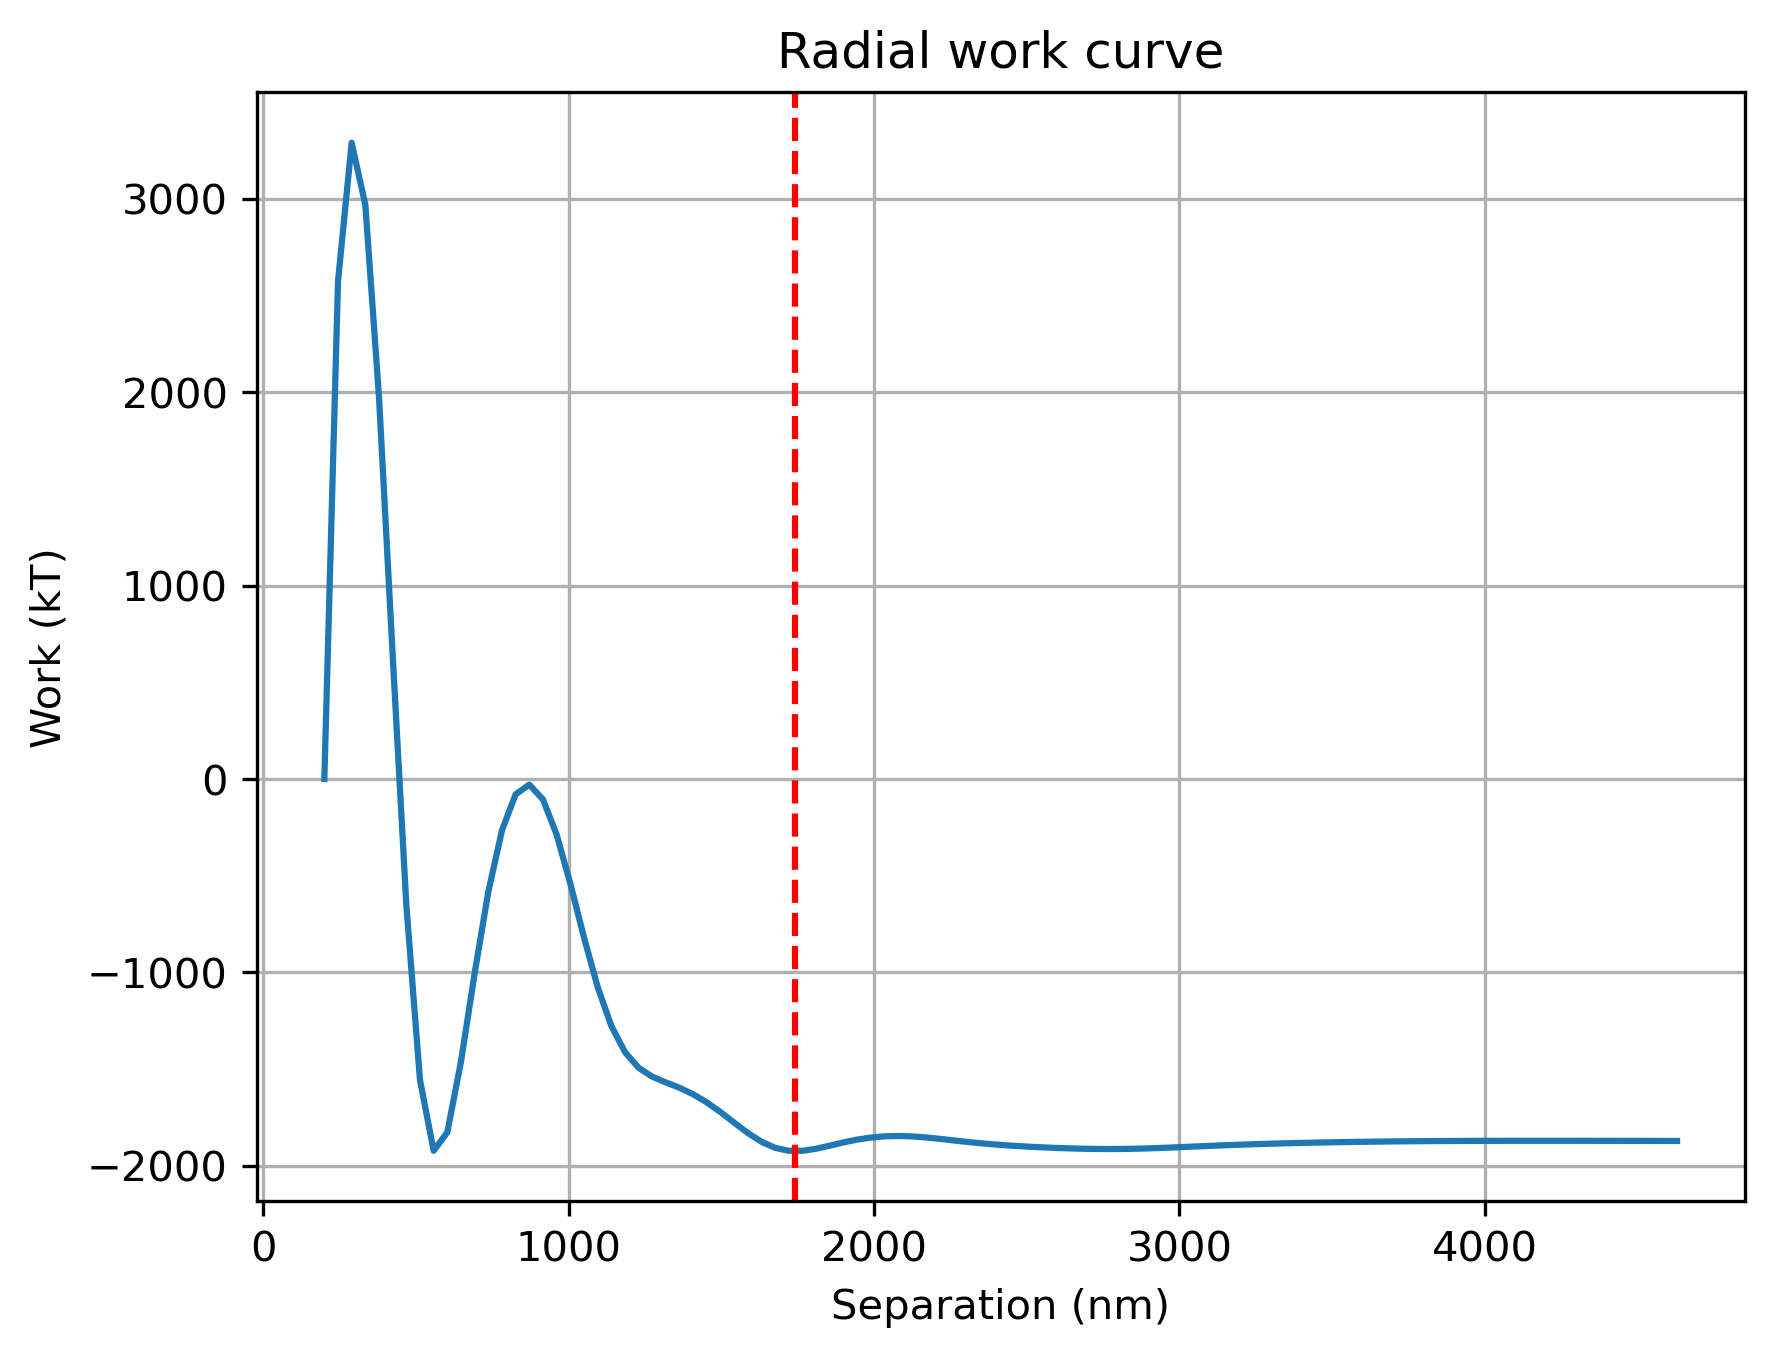

In [70]:
plt.figure(dpi=300)
plt.grid()
plt.plot(optim.separation / nm, W / kT)
plt.axvline(optim.target_dist / nm, c='r', linestyle='--')
plt.xlabel('Separation (nm)')
plt.ylabel('Work (kT)')
plt.title('Radial work curve')
plt.show()

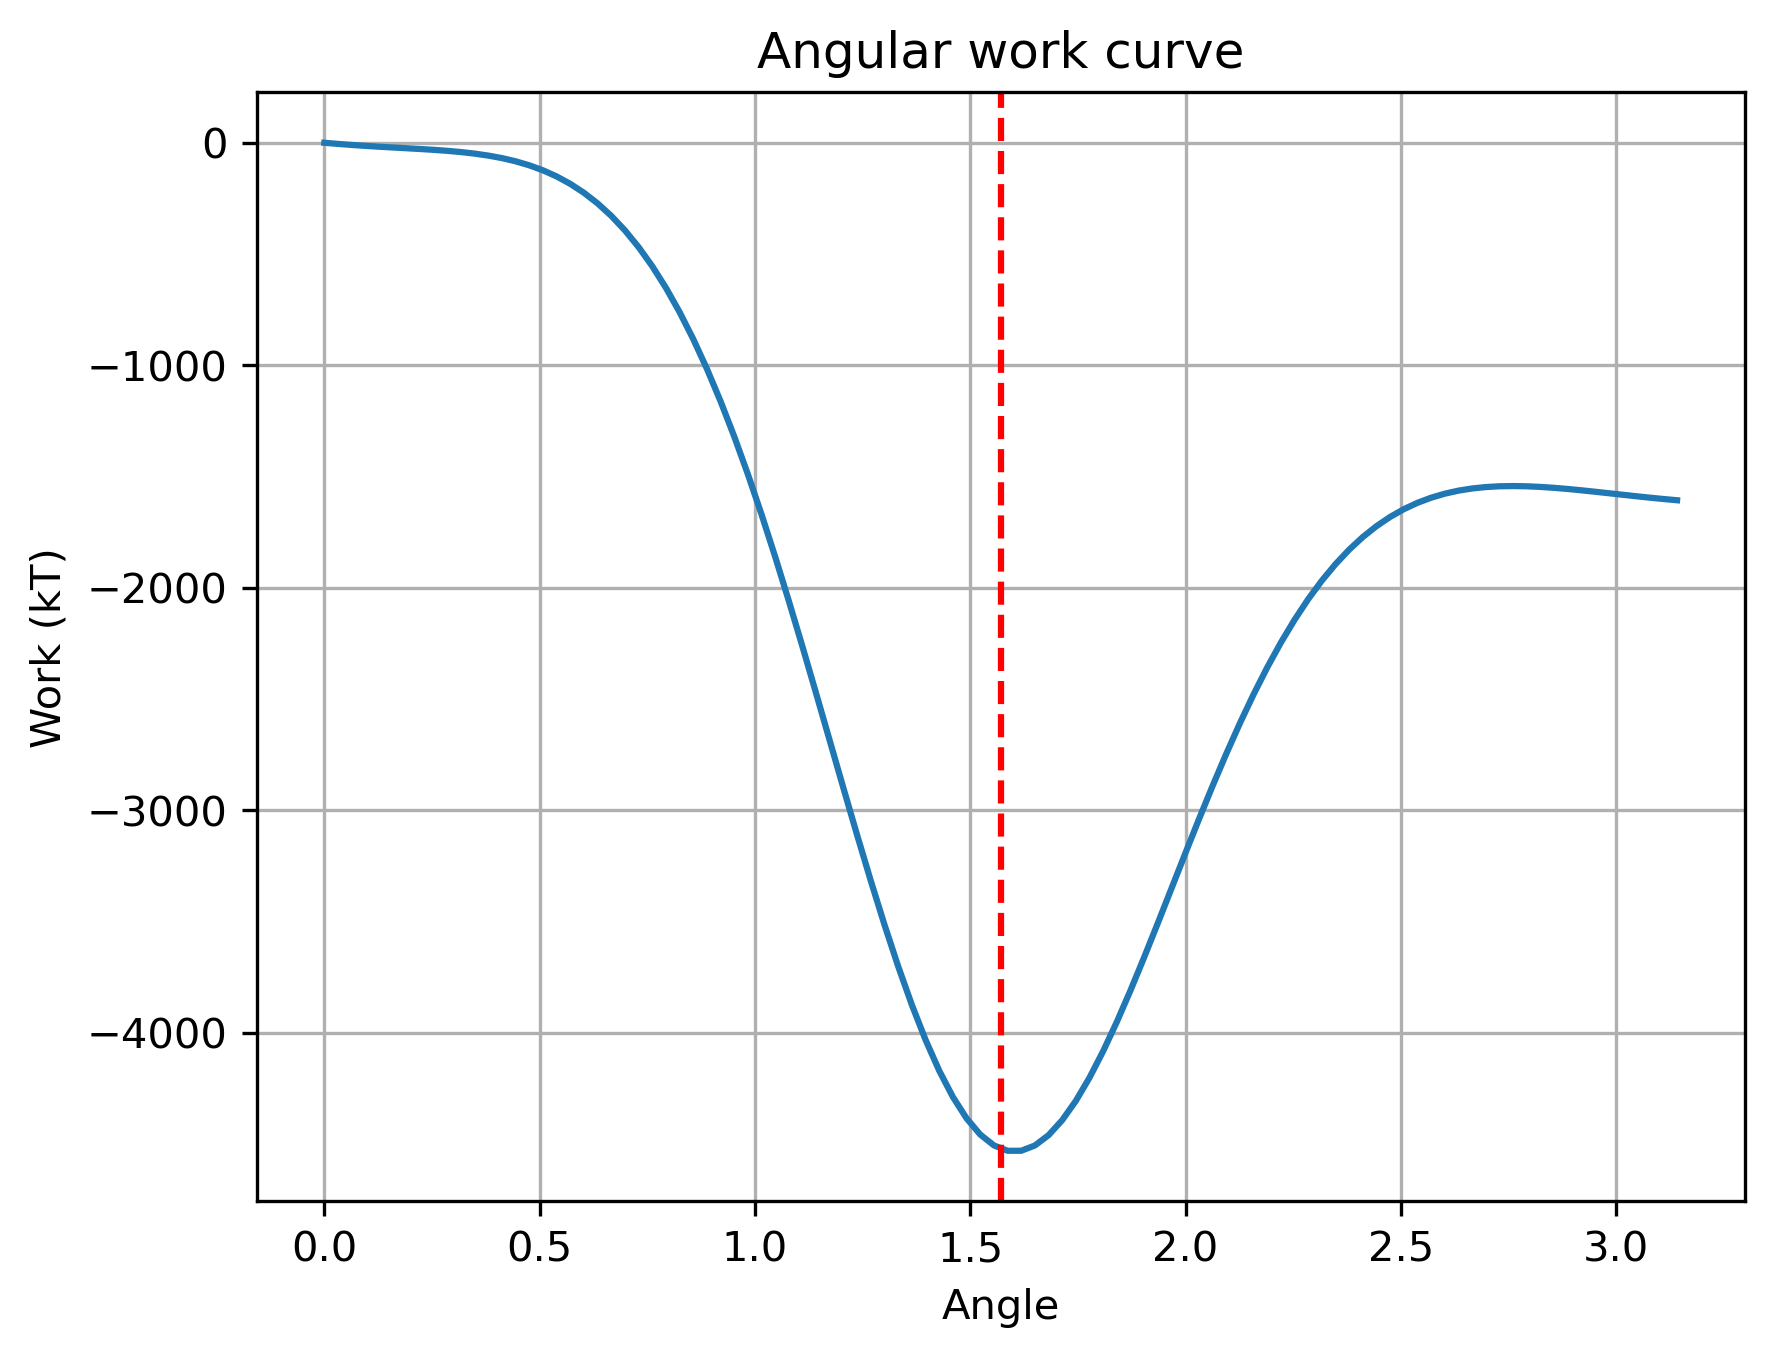

In [71]:
plt.figure(dpi=300)
plt.grid()
plt.plot(optim.thetas, W_angle / kT)
plt.axvline(optim.target_angle, c='r', linestyle='--')
plt.xlabel('Angle')
plt.ylabel('Work (kT)')
plt.title('Angular work curve')
plt.show()

In [72]:
size = 2000*nm
Nx = 32
### X,Y grid for computing fields
x = np.linspace(-size/2, size/2, Nx)
y = np.linspace(-size/2, size/2, Nx)
X, Y = np.meshgrid(x, y, indexing='ij')
Z = np.zeros_like(X)

E = optim.dimer._get_source(anm).E_field(X, Y, Z, optim.dimer.k, sampling=optim.dimer.e_field_sampling)

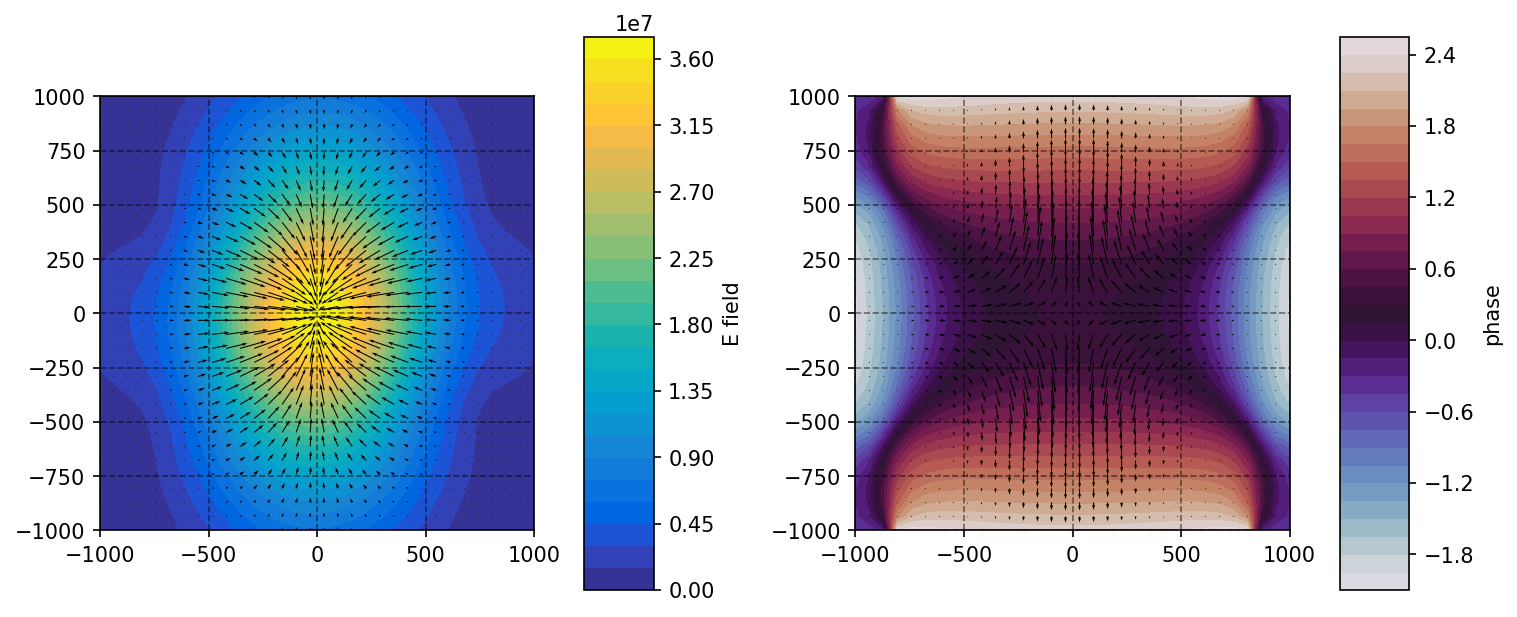

In [73]:
from my_pytools.my_matplotlib.colors import cmap

fig, ax = plt.subplots(ncols=2, figsize=(10,4), constrained_layout=True, dpi=150)

I = np.sum(np.abs(E)**2, axis=0)
im = ax[0].contourf(X/nm, Y/nm, I**.5, cmap=cmap['parula'], levels=30)
plt.colorbar(im, ax=ax[0], label='E field')

dx, dy = np.gradient(I)
#norm = np.linalg.norm(np.array((dx, dy)), axis=0)
#dx = dx / norm
#dy = dy / norm
ax[0].quiver(X/nm, Y/nm, dx, dy)

phase = np.angle(E[0] - 1j*E[1])
im = ax[1].contourf(X/nm, Y/nm, phase, cmap='twilight', levels=30)
plt.colorbar(im, ax=ax[1], label='phase')

dx, dy = I * np.gradient(phase)
ax[1].quiver(X/nm, Y/nm, dx, dy)

for axs in ax:
    axs.set_aspect('equal')
    axs.grid(color='k', linestyle='dashed', alpha=0.5)
plt.show()

In [74]:
from src.utils import slm

In [75]:
Nx = 256
theta = np.linspace(0, 1, Nx)
phi = np.linspace(0, 2 * np.pi, Nx)
THETA, PHI = np.meshgrid(theta, phi, indexing='ij')
x = np.sin(THETA) * np.cos(PHI)
y = np.sin(THETA) * np.sin(PHI)
phase = slm(THETA, PHI, anm, optim.dimer.Nmax, optim.dimer.rho_scale)
phase.max() - phase.min()

2.6360951129664025

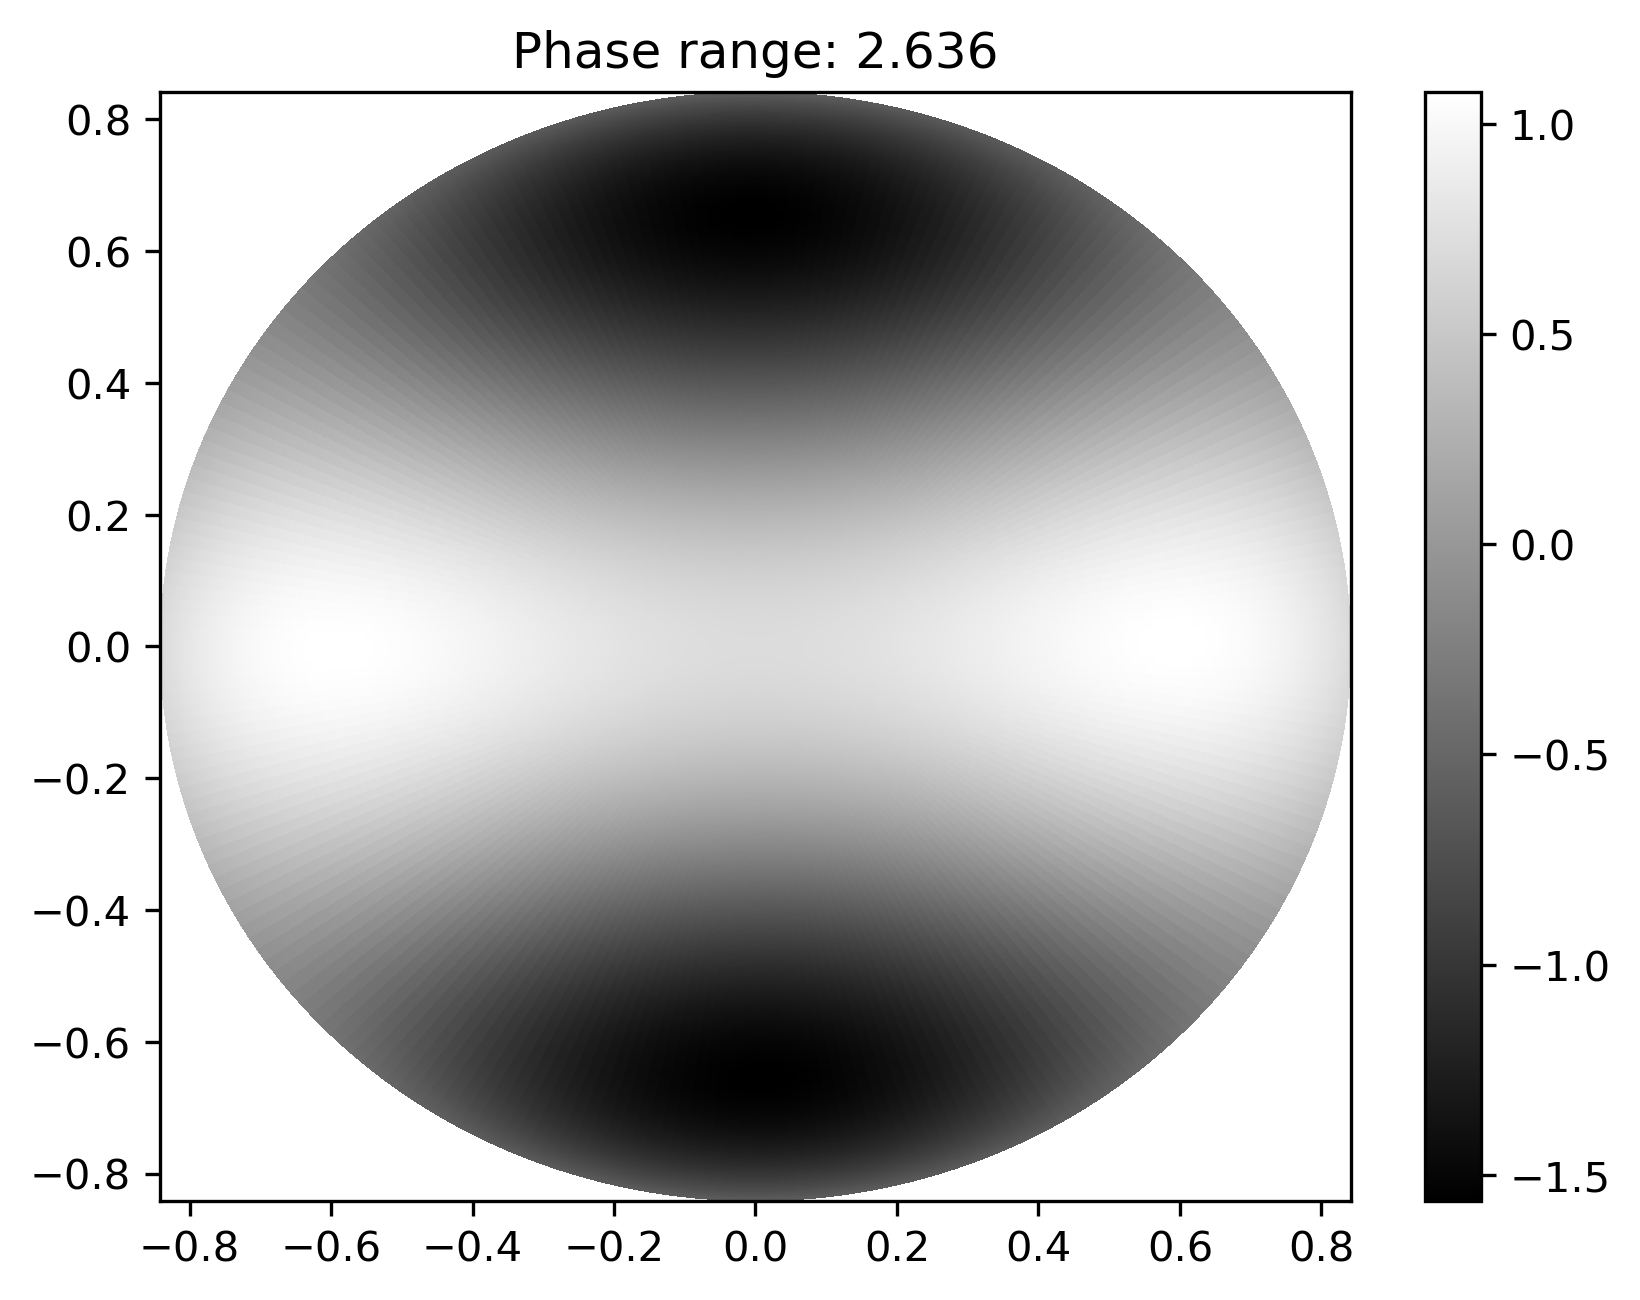

In [76]:
plt.figure(dpi=300)
im= plt.pcolormesh(x, y, phase, shading='gourard', rasterized=True, cmap='gray')
plt.colorbar(im)
plt.title(f'Phase range: {phase.max() - phase.min():.4g}')
plt.show()

In [2]:
import matplotlib
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.rcParams['animation.ffmpeg_path'] = '/project2/andrewferguson/Kirill/env_kirills/bin/ffmpeg'
plt.ioff()
fig, ax = plt.subplots(ncols=2, figsize=(10,4), constrained_layout=True)

I = np.sum(np.abs(E)**2, axis=0)
im = ax[0].contourf(X/nm, Y/nm, I**.5, cmap=cmap['parula'], levels=30)
plt.colorbar(im, ax=ax[0], label='E field')

phase = np.angle(E[0] - 1j*E[1])
im = ax[1].contourf(X/nm, Y/nm, phase, cmap='twilight', levels=30)
plt.colorbar(im, ax=ax[1], label='phase')

for axs in ax:
    axs.set_aspect('equal')
    axs.set_xlabel('x (nm)')
    axs.set_ylabel('y (nm)')
    axs.grid(color='k', linestyle='dashed', alpha=0.5)


pos_frames = pos[::200][:100]#[:ms2steps(100)][::100]
for p in pos_frames[0]:
    
    C = plt.Circle(p[:2]/nm, radius=optim.dimer.radius / nm, color='C3')
    ax[0].add_patch(C)
    C = plt.Circle(p[:2]/nm, radius=optim.dimer.radius / nm, color='C3')
    ax[1].add_patch(C)

def update(t):
    pos_t = pos_frames[t]
    ax[0].patches = []
    ax[0].grid(color='k', linestyle='dashed', alpha=0.5)
    ax[1].patches = []
    ax[1].grid(color='k', linestyle='dashed', alpha=0.5)
    for p in pos_t:
        C = plt.Circle(p[:2]/nm, radius=optim.dimer.radius / nm, color='C3')
        ax[0].add_patch(C)
        C = plt.Circle(p[:2]/nm, radius=optim.dimer.radius / nm, color='C3')
        ax[1].add_patch(C)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=100)
ani

NameError: name 'plt' is not defined